In [1]:
from qutip import *
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from quantum_logical.channel import AmplitudeDamping, PhaseDamping
from quantum_logical.trotter import TrotterGroup
from tqdm import tqdm
from quantum_logical.operators import selective_destroy
from scipy.optimize import curve_fit

In [2]:
# generating parameters and creating initial state
T1 = 1600
T2 = 1000
N = 5
dim = 2
trotter_dt = .02
psi0 = qt.tensor((qt.basis(dim, 1)).unit(), qt.basis(dim, 0), qt.basis(dim, 0), qt.basis(dim, 0), qt.basis(dim, 0))
# psi0 = qt.basis(dim, 1)
rho0 = psi0 * psi0.dag()
amp_damp_channel = AmplitudeDamping(T1, num_qubits=N, hilbert_space_dim=dim)
phase_damp_channel = PhaseDamping(T1, T2, num_qubits=N, hilbert_space_dim=dim)
trotter = TrotterGroup(
    continuous_operators=[amp_damp_channel, phase_damp_channel],
    trotter_dt=trotter_dt,
)


# qt.Qobj(amp_damp_channel._create_single_qubit_operators(T1=1)[1])
# identity = qt.qeye(dim ** N)

In [3]:
# creating the set of cnots
cnot1 = qt.cnot(N=5, control=0, target=1)
cnot2 = qt.cnot(N=5, control=0, target=2)

cnot3 = qt.cnot(N=5, control=0, target=3)
cnot4 = qt.cnot(N=5, control=1, target=3)

cnot5 = qt.cnot(N=5, control=1, target=4)
cnot6 = qt.cnot(N=5, control=2, target=4)

z_gate = qt.Qobj([[1, 0], [0, -1]])

hada = 1/np.sqrt(2) * qt.Qobj([[1, 1], [1, -1]])

hada_layer = qt.tensor(hada, hada, hada, qt.qeye(dim), qt.qeye(dim))


/var/folders/nc/8sqqbv456mdfx096ks86vy8m0000gn/T/ipykernel_34259/1560948042.py:2: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  cnot1 = qt.cnot(N=5, control=0, target=1)
/var/folders/nc/8sqqbv456mdfx096ks86vy8m0000gn/T/ipykernel_34259/1560948042.py:3: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  cnot2 = qt.cnot(N=5, control=0, target=2)
/var/folders/nc/8sqqbv456mdfx096ks86vy8m0000gn/T/ipykernel_34259/1560948042.py:5: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instea

In [4]:
# creating the initial state and encoding it 
psi0 = qt.tensor(qt.basis(dim, 1), qt.basis(dim, 0), qt.basis(dim, 0), qt.basis(dim, 0), qt.basis(dim, 0))
rho0 = psi0 * psi0.dag()
rho_encoded = hada_layer * cnot2 * cnot1 * rho0 * cnot1.dag() * cnot2.dag() * hada_layer.dag()
# trace out the ancillas to get the true result
rho_encoded_traced = qt.ptrace(rho_encoded, [0, 1, 2])
# the correct initial state has been prepared 
rho_encoded_traced 

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.125 -0.125 -0.125  0.125 -0.125  0.125  0.125 -0.125]
 [-0.125  0.125  0.125 -0.125  0.125 -0.125 -0.125  0.125]
 [-0.125  0.125  0.125 -0.125  0.125 -0.125 -0.125  0.125]
 [ 0.125 -0.125 -0.125  0.125 -0.125  0.125  0.125 -0.125]
 [-0.125  0.125  0.125 -0.125  0.125 -0.125 -0.125  0.125]
 [ 0.125 -0.125 -0.125  0.125 -0.125  0.125  0.125 -0.125]
 [ 0.125 -0.125 -0.125  0.125 -0.125  0.125  0.125 -0.125]
 [-0.125  0.125  0.125 -0.125  0.125 -0.125 -0.125  0.125]]

In [5]:
# store the states and the fidelities that come out
states = []
fids = []

In [6]:
# run the circuit 
initial_time = 10
initial_state_relax = trotter.apply(rho_encoded, duration=initial_time, discrete_unitary=qt.qeye(dim ** N))
for i in range(len(initial_state_relax)):
    states.append(hada_layer * initial_state_relax[i] * hada_layer.dag()) # this is done in order to make sure that the states are saved in the computational basis 
fids.append(qt.fidelity(qt.ptrace(initial_state_relax[-1], [0, 1, 2]), rho_encoded_traced))

# layer of hadamard that will put back in the computational basis 
hada_layer_after_encoding = hada_layer * initial_state_relax[-1] * hada_layer.dag() # now in computational basis 
#  no need to recalculate fidelity since this is instantaneous so this wont change it but can use it as a check 
states.append(hada_layer_after_encoding)

# now apply the cnots to the circuit 
cnot_gate_overall = cnot6 * cnot5 * cnot4 * cnot3

syndrome_time = 40
after_syndrome_extraction = trotter.apply(hada_layer_after_encoding, duration= syndrome_time, discrete_unitary=cnot_gate_overall)
states.extend(after_syndrome_extraction)
a = hada_layer * after_syndrome_extraction[-1] * hada_layer.dag() # in order to check the fidelity need to make sure that the states are in the same encoded basis 
fids.append(qt.fidelity(qt.ptrace(a, [0, 1, 2]), rho_encoded_traced))

# putting the states back in the x basis 
a = hada_layer * after_syndrome_extraction[-1] * hada_layer.dag()
states.append(hada_layer * a * hada_layer.dag()) # keeping the state in the computational basis for plotting 

In [7]:
r00 = qt.tensor(qt.qeye(dim ** N))
r01 = qt.Qobj((qt.tensor(qt.qeye(dim), z_gate, qt.qeye(dim ** 3))).full())
r10 = qt.Qobj((qt.tensor(z_gate, qt.qeye(dim ** 4))).full())
r11 = qt.Qobj((qt.tensor(qt.qeye(dim), qt.qeye(dim), z_gate, qt.qeye(dim ** 2))).full())

In [8]:
# recovery algorithm
correction_op = (r00 * qt.Qobj(qt.tensor(qt.qeye(dim), qt.qeye(dim), qt.qeye(dim), (qt.tensor(qt.basis(dim, 0), qt.basis(dim, 0)) * (qt.tensor(qt.basis(dim, 0), qt.basis(dim, 0))).dag())).full()) +
                 r01 * qt.Qobj(qt.tensor(qt.qeye(dim), qt.qeye(dim), qt.qeye(dim), (qt.tensor(qt.basis(dim, 0), qt.basis(dim, 1)) * (qt.tensor(qt.basis(dim, 0), qt.basis(dim, 1))).dag())).full()) +
                 r10 * qt.Qobj(qt.tensor(qt.qeye(dim), qt.qeye(dim), qt.qeye(dim), (qt.tensor(qt.basis(dim, 1), qt.basis(dim, 0)) * (qt.tensor(qt.basis(dim, 1), qt.basis(dim, 0))).dag())).full()) +
                 r11 * qt.Qobj(qt.tensor(qt.qeye(dim), qt.qeye(dim), qt.qeye(dim), (qt.tensor(qt.basis(dim, 1), qt.basis(dim, 1)) * (qt.tensor(qt.basis(dim, 1), qt.basis(dim, 1))).dag())).full())
)

measurement_dur = 1
# measurement = trotter.apply(final_state, duration=measurement_dur, discrete_unitary=qt.qeye(dim ** N))
measurement = trotter.apply(a, duration=measurement_dur, discrete_unitary=correction_op)
for i in range(len(measurement)):
    states.append(hada_layer * measurement[i] * hada_layer.dag())
# states.extend(measurement)
fids.append(qt.fidelity(qt.ptrace(measurement[-1], [0, 1, 2]), rho_encoded_traced))

In [9]:
# final relaxation cycle
relaxation_time = 10
relaxation = trotter.apply(measurement[-1], duration=relaxation_time, discrete_unitary=qt.qeye(dim ** N))
for i in range(len(relaxation)):
    states.append(hada_layer * relaxation[i] * hada_layer.dag())
fids.append(qt.fidelity(qt.ptrace(relaxation[-1], [0, 1, 2]), rho_encoded_traced))

In [10]:
total_cirquit_duration = initial_time + syndrome_time + relaxation_time + measurement_dur
time_list = np.linspace(0, total_cirquit_duration, len(states))

In [11]:
# trace out the ancillas
state_sim = []
for i in range(len(states)):
    state_sim.append(qt.ptrace(states[i], [0, 1, 2]))

state_sim[0] # checking that the tracing out worked 

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.24998047e-07
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.24999219e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 6.24998047e-07 0.00000000e+00 1.24999219e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 6.24998047e-07 1.24999219e-06]
 [0.00000000e+00 0.0000

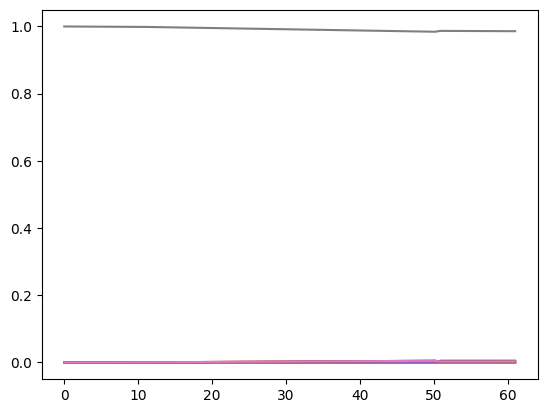

In [12]:
# plot
fig, ax = plt.subplots()
for i in range(dim ** 3):
    datas = []
    for j in range(len(state_sim)):
        # print(np.real(states[j][i, i]))
        datas.append(np.real(state_sim[j][i, i]))  
    ax.plot(time_list, datas)
# datas = []
# for i in range(len(states)- 12000):
#     print(np.real(states[i][0, 0])) 
#     datas.append(np.real(states[i][0, 0]))

# ax.plot(time_list[0:38032], datas)

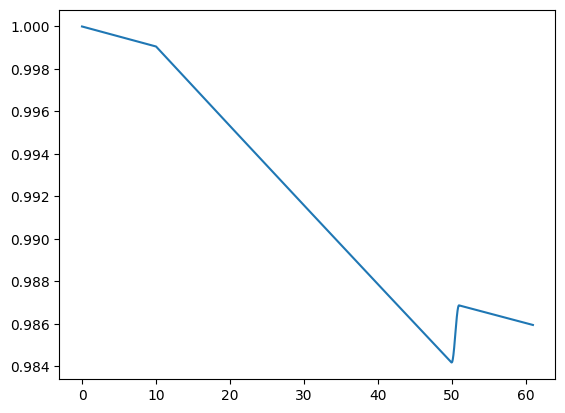

In [13]:
# label these plots with the states
fig, ax = plt.subplots()
datas = []
for j in range(len(state_sim)):
    # print(np.real(states[j][i, i]))
    datas.append(np.real(state_sim[j][7, 7]))    
ax.plot(time_list, datas)

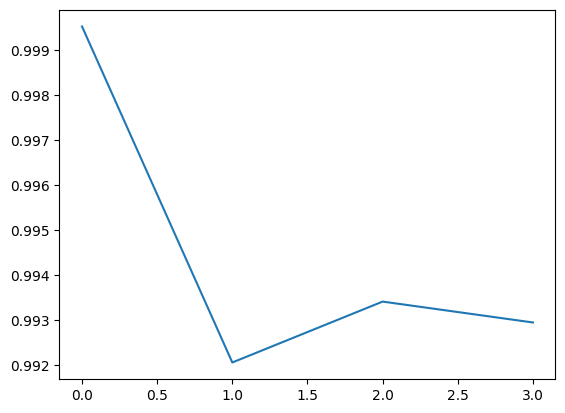

In [14]:
# for this to make the most sense you need to plot fidelity 
fid_stops = []
for i in range(len(fids)):
    fid_stops.append(i)

fig, ax = plt.subplots()
ax.plot(fid_stops, fids)

In [15]:
fids

[0.9995314491625367,
 0.9920631924828679,
 0.9934164720968474,
 0.9929521740934452]